In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import MeanIoU
from sklearn.metrics import jaccard_score, f1_score


In [18]:
from glob import glob
import os

# Function to get all file paths regardless of extension
def get_all_file_paths(root_dir):
    return sorted(glob(os.path.join(root_dir, "*", "*")))  # all files in subfolders

# Root directories
img_root = "/kaggle/input/plant-village-unet/U_NET_TRAINING/PlantVillage_dataset"
mask_root = "/kaggle/input/plant-village-unet/U_NET_TRAINING/masks"

# Collect image and mask paths
image_paths = get_all_file_paths(img_root)
mask_paths = get_all_file_paths(mask_root)

print("Total images found:", len(image_paths))
print("Total masks found:", len(mask_paths))


Total images found: 2152
Total masks found: 2152


In [19]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tqdm import tqdm

IMG_SIZE = 256

def preprocess(path, mask=False):
    try:
        img = load_img(path, target_size=(IMG_SIZE, IMG_SIZE), color_mode='grayscale' if mask else 'rgb')
        img = img_to_array(img) / 255.0
        if mask:
            img = np.where(img > 0.5, 1, 0)  # Binarize mask
        return img
    except Exception as e:
        print(f"Skipping file {path}: {e}")
        return None

# Load and preprocess valid images only
X, Y = [], []

for img_path, mask_path in tqdm(zip(image_paths, mask_paths), total=min(len(image_paths), len(mask_paths))):
    img = preprocess(img_path, mask=False)
    mask = preprocess(mask_path, mask=True)

    if img is not None and mask is not None:
        X.append(img)
        Y.append(mask)

X = np.array(X)
Y = np.array(Y)

print("Final shapes -> X:", X.shape, "Y:", Y.shape)


100%|██████████| 2152/2152 [00:13<00:00, 156.23it/s]


Final shapes -> X: (2152, 256, 256, 3) Y: (2152, 256, 256, 1)


In [20]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
print(X_train.shape, Y_train.shape)


(1721, 256, 256, 3) (1721, 256, 256, 1)


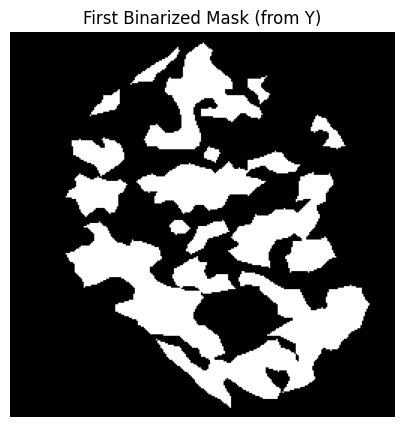

Unique pixel values in Y[0]: [0 1]


In [21]:
import matplotlib.pyplot as plt

# Plot the first binarized mask
plt.figure(figsize=(5, 5))
plt.imshow(Y[0].squeeze(), cmap='gray')
plt.title("First Binarized Mask (from Y)")
plt.axis('off')
plt.show()

# Optionally, print unique pixel values to confirm binarization
print("Unique pixel values in Y[0]:", np.unique(Y[0]))


In [22]:
from tensorflow.keras import layers, models

def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D()(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, 2, strides=2, padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model



In [24]:


model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 256, 256, 64)   │          1,792 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ conv2d_38[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 128, 128, 64)   │              0 │ conv2d_39[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_40 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_41 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ conv2d_40[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 64, 64, 128)    │              0 │ conv2d_41[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_42 (Conv2D)        │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_43 (Conv2D)        │ (None, 64, 64, 256)    │        590,080 │ conv2d_42[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 32, 32, 256)    │              0 │ conv2d_43[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_44 (Conv2D)        │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_45 (Conv2D)        │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_44[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 16, 16, 512)    │              0 │ conv2d_45[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_46 (Conv2D)        │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_47 (Conv2D)        │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_46[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_8        │ (None, 32, 32, 512)    │      2,097,664 │ conv2d_47[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_8        

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history = model.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    epochs=20,
                    batch_size=8)


Epoch 1/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 124s 514ms/step - accuracy: 0.8664 - loss: 0.4954 - val_accuracy: 0.8926 - val_loss: 0.2575
Epoch 2/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 106s 489ms/step - accuracy: 0.8984 - loss: 0.2553 - val_accuracy: 0.9195 - val_loss: 0.2224
Epoch 3/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 105s 486ms/step - accuracy: 0.9082 - loss: 0.2370 - val_accuracy: 0.9248 - val_loss: 0.2025
Epoch 4/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 103s 476ms/step - accuracy: 0.8797 - loss: 8247.7773 - val_accuracy: 0.8685 - val_loss: 0.3605
Epoch 5/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 101s 469ms/step - accuracy: 0.8678 - loss: 0.3606 - val_accuracy: 0.8685 - val_loss: 0.3549
Epoch 6/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 101s 468ms/step - accuracy: 0.8583 - loss: 0.3620 - val_accuracy: 0.8685 - val_loss: 0.3354
Epoch 7/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 101s 467ms/step - accuracy: 0.8641 - loss: 0.3484 - val_accuracy: 0.8685 - val_loss: 0.3338
Epoch 8/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 101s 466ms/step - accuracy: 0.857

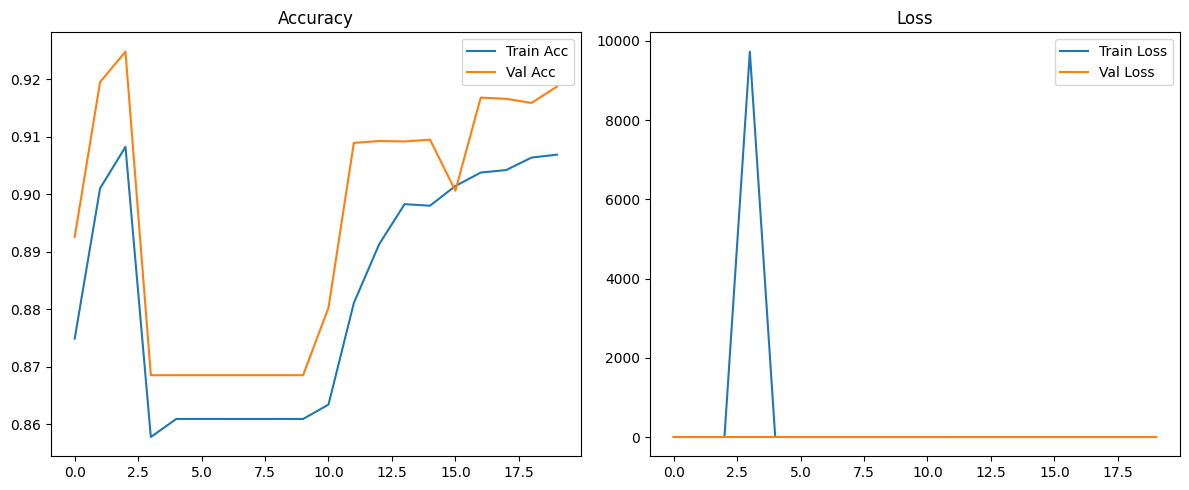

In [26]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [27]:
def evaluate_model(model, X_val, Y_val):
    preds = model.predict(X_val)
    preds_bin = (preds > 0.5).astype(np.uint8)

    ious = []
    dice_scores = []
    for i in range(len(Y_val)):
        y_true = Y_val[i].flatten()
        y_pred = preds_bin[i].flatten()
        ious.append(jaccard_score(y_true, y_pred, zero_division=1))
        dice_scores.append(f1_score(y_true, y_pred, zero_division=1))

    print(f"Mean IoU: {np.mean(ious):.4f}")
    print(f"Mean Dice Coefficient: {np.mean(dice_scores):.4f}")


2025-05-06 17:57:43.972694: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[32,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,128,128]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-05-06 17:57:44.267077: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.294642891s
Trying algorithm eng12{k11=0} for conv (f32[32,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,128,128]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivatio

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step

E0000 00:00:1746554320.205982      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746554320.446635      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


14/14 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step 
Mean IoU: 0.5050
Mean Dice Coefficient: 0.6411
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


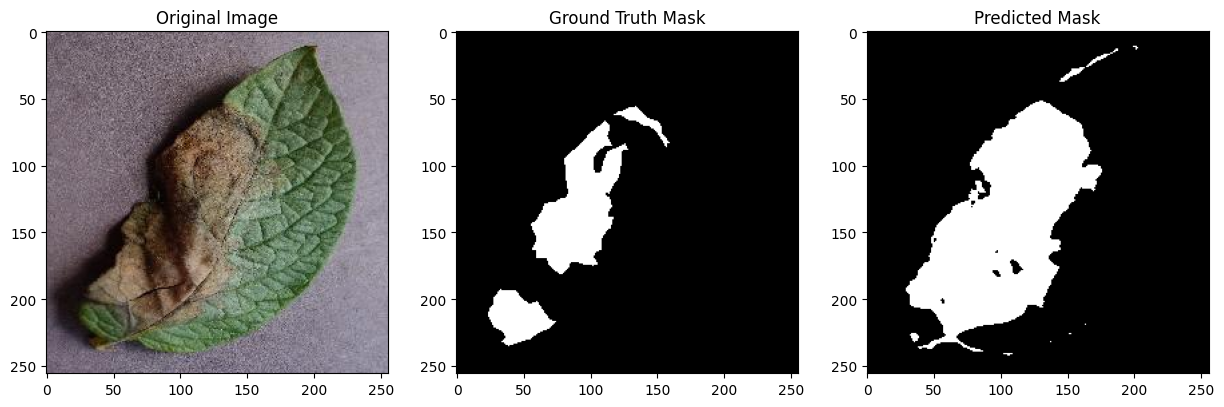

In [28]:
def test_and_plot(index, model, X_val, Y_val):
    img = X_val[index]
    gt_mask = Y_val[index]
    pred = model.predict(img[np.newaxis, ...])[0]
    pred_mask = (pred > 0.5).astype(np.uint8)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(img)

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(gt_mask.squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask.squeeze(), cmap='gray')
    plt.show()

# Example usage
evaluate_model(model, X_val, Y_val)
test_and_plot(0, model, X_val, Y_val)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


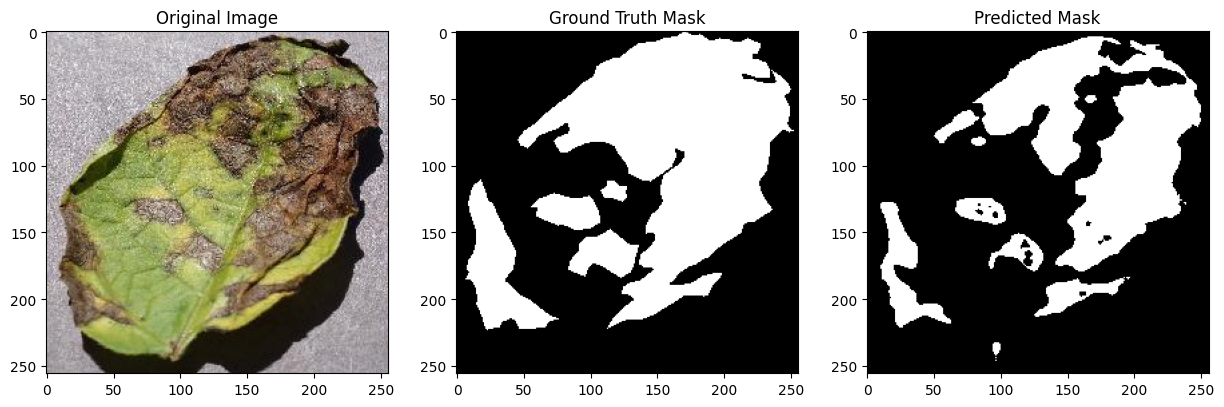

In [32]:
img = X_val[14]
gt_mask = Y_val[14]
pred = model.predict(img[np.newaxis, ...])[0]
pred_mask = (pred > 0.5).astype(np.uint8)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img)

plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask")
plt.imshow(gt_mask.squeeze(), cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(pred_mask.squeeze(), cmap='gray')
plt.show()